<a href="https://colab.research.google.com/github/maticly/DataAnalyticsAgent/blob/main/DataAnalyticsAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analytics Agent**

# Overview:

**Key Components:**
*   **Google Gemini (GenAI API):** Used for the agent's reasoning capabilities.
*   **ReAct Pattern:** The agent follows a Think → Act → Observe loop to solve user queries.
*   **Short-term Memory (ConversationMemory):** Stores recent conversation turns to maintain context.
*   **Long-term Memory (_DATASET_STORE):** Stores loaded datasets for persistent access.
*   **Tools:**
    *   `LoadCSVTool`: For loading datasets (though not explicitly used in the provided notebook, it's a conceptual tool).
    *   `ListDatasetsTool`: Lists currently loaded datasets.
    *   `InspectDatasetTool`: Provides detailed information about a specified dataset.
    *   `AnalyzeTool`: Generates and executes pandas code for data analysis.
    *   `VisualizeTool`: Generates and executes matplotlib/seaborn code for data visualization.
*   **SafeCodeExecutor:** A sandboxed environment to safely execute generated Python code.



---


**Project Structure**
```
Agent Core (DataAnalyticsAgent)
├── Memory System (ConversationMemory) - Short-term memory
├── Dataset Store (_DATASET_STORE) - Long-term memory (global dictionary)
├── Code Executor (SafeCodeExecutor)
└── Tools
    ├── BaseTool (Abstract Base Class)
    ├── ListDatasetsTool - Lists available data
    ├── InspectDatasetTool - Examines datasets
    ├── AnalyzeTool - Generates & runs analysis code
    └── VisualizeTool - Generates & creates plots
├── Agent Prompt Builder (build_agent_prompt)
└── Interface (ColabAgentInterface) - User interaction
```


# **LLM Installation**

In [3]:
import google.generativeai as genai
from google.colab import userdata

# Configure API
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

# Initialize the Model
model = genai.GenerativeModel('models/gemini-2.5-flash')
prompt = "what is 4+5. Answer with 1 token only"
response = model.generate_content(prompt)
print(response.text)


9


# **1: Dependency Installation**

**Dependency Installation:**
    *   Installs necessary libraries like `google-generativeai`, `pandas`, `matplotlib`, and `seaborn`.
    *   Imports all required modules.

In [17]:
!pip install -q google-generativeai pandas matplotlib seaborn

import google.generativeai as genai
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import logging
import os
import sys
import io
import time
from typing import Dict, List, Any, Optional
from abc import ABC, abstractmethod
from collections import deque
from IPython.display import display, Image, Markdown, clear_output
import ipywidgets as widgets

# **2: Dataset Loading**

**Dataset Loading**
*   The `insurance.csv` dataset is loaded from KaggleHub into a pandas DataFrame named `df`.
*   Basic exploration and initial visualizations of the dataset are performed to understand its structure and content.


In [46]:
# load dataset
"""
Medical_Insurance cost Dataset
    source: https://www.kaggle.com/datasets/varishabatool/data-set
"""

import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "insurance.csv"

# Load the latest version of the dataset
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "varishabatool/data-set",
    file_path
)

/tmp/ipython-input-1828922015.py:13: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'data-set' dataset.



🔍 Dataset Overview:
Rows: 1338
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Mean of Age: 39.21
Median of Age: 39.0

Standard Deviation of Age: 14.049960379216172
Variance of Age: 197.40138665754424
---------------------------------------------------------------------------
<bound method NDFrame.describe of       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   16

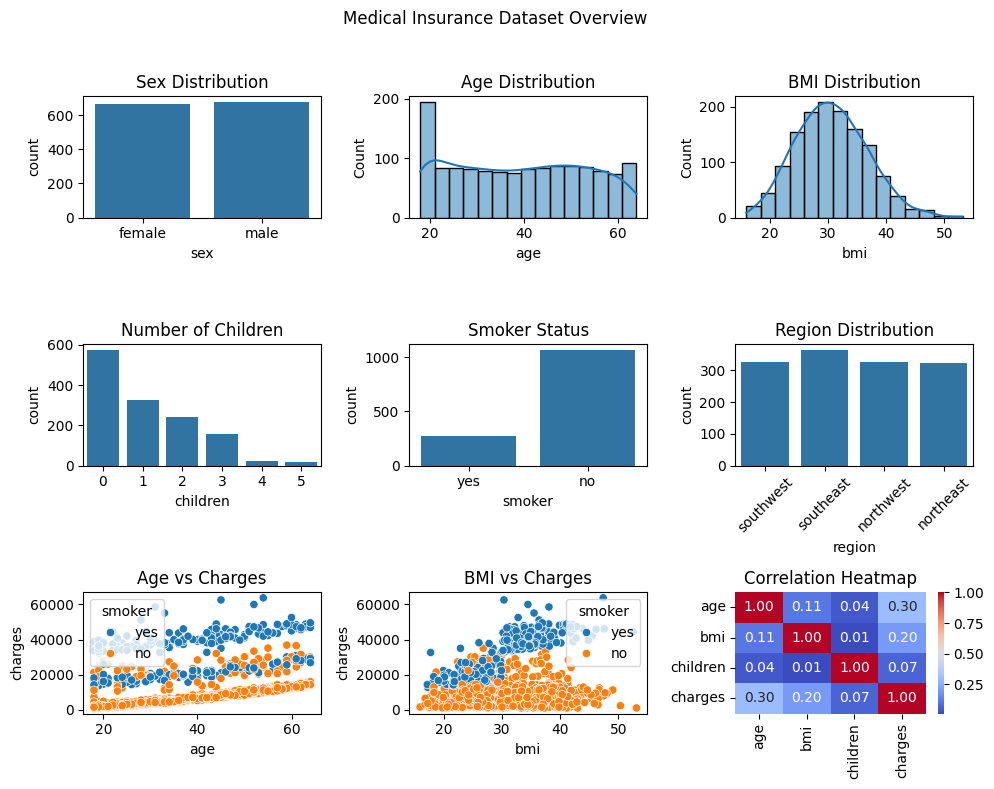

In [47]:
# Basic dataset exploration
print("\n🔍 Dataset Overview:")
print(f"Rows: {len(df)}")
print(f"Columns: {list(df.columns)}")
print("\nMean of Age:", round(df['age'].mean() ,2))
print("Median of Age:", round(df['age'].median(), 2))
print("\nStandard Deviation of Age:", df['age'].std())
print("Variance of Age:", df['age'].var())

print("-"*75)

print(df.describe)
print(df.head(10))

print("-"*75)

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the layout
plt.figure(figsize=(10, 8))
plt.suptitle("Medical Insurance Dataset Overview", fontsize=12)

# 1. Sex distribution (bar plot)
plt.subplot(3, 3, 1)
sns.countplot(x='sex', data=df)
plt.title("Sex Distribution")

# 2. Age histogram
plt.subplot(3, 3, 2)
sns.histplot(df['age'], bins=15, kde=True)
plt.title("Age Distribution")

# 3. BMI histogram
plt.subplot(3, 3, 3)
sns.histplot(df['bmi'], bins=15, kde=True)
plt.title("BMI Distribution")

# 4. Children count
plt.subplot(3, 3, 4)
sns.countplot(x='children', data=df)
plt.title("Number of Children")

# 5. Smoker distribution
plt.subplot(3, 3, 5)
sns.countplot(x='smoker', data=df)
plt.title("Smoker Status")

# 6. Region distribution
plt.subplot(3, 3, 6)
sns.countplot(x='region', data=df)
plt.title("Region Distribution")
plt.xticks(rotation=45)

# 7. Age vs Charges (scatter)
plt.subplot(3, 3, 7)
sns.scatterplot(x='age', y='charges', hue='smoker', data=df)
plt.title("Age vs Charges")

# 8. Charges vs BMI (scatter)
plt.subplot(3, 3, 8)
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title("BMI vs Charges")

# 9. Correlation heatmap
plt.subplot(3, 3, 9)
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**BMI Image**
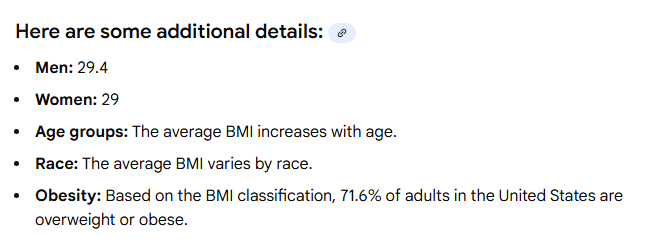

In [48]:
df_v1 = df.copy()

# **3: Base Tool**

In [49]:
class BaseTool(ABC):
    """Abstract base class for all tools."""

    @property
    @abstractmethod
    def name(self) -> str:
        pass

    @property
    @abstractmethod
    def description(self) -> str:
        pass

    @property
    @abstractmethod
    def parameters(self) -> Dict[str, Any]:
        pass

    @abstractmethod
    def execute(self, **kwargs) -> Dict[str, Any]:
        pass

    def to_dict(self) -> Dict[str, Any]:
        return {
            "name": self.name,
            "description": self.description,
            "parameters": self.parameters
        }

# **4: Dataset Store & Tools**

**Dataset Store & Tools:**
*   `_DATASET_STORE`: A global dictionary `_DATASET_STORE` acts as long-term memory for datasets, storing `pd.DataFrame` objects.
*   `ListDatasetsTool`: Allows the agent to list all datasets it currently has access to.
*   `InspectDatasetTool`: Enables the agent to get a summary and first few rows of any loaded dataset.

In [50]:
# Global dataset storage (long-term memory)
_DATASET_STORE: Dict[str, pd.DataFrame] = {}

class LoadCSVTool(BaseTool):
    """Load a CSV file into the dataset store."""

    @property
    def name(self) -> str:
        return "load_csv"

    @property
    def description(self) -> str:
        return "Load a CSV file into memory with an alias for reference."

    @property
    def parameters(self) -> Dict[str, Any]:
        return {
            "type": "object",
            "properties": {
                "filepath": {"type": "string", "description": "Path to CSV"},
                "alias": {"type": "string", "description": "Dataset name"}
            },
            "required": ["filepath", "alias"]
        }

    def execute(self, filepath: str, alias: str) -> Dict[str, Any]:
        try:
            df = pd.read_csv(filepath)
            _DATASET_STORE[alias] = df
            return {
                "status": "success",
                "result": f"Loaded '{filepath}' as '{alias}' with {len(df)} rows, {len(df.columns)} columns. Columns: {list(df.columns)}"
            }
        except Exception as e:
            return {"status": "error", "error_message": f"Failed to load: {str(e)}"}


class ListDatasetsTool(BaseTool):
    @property
    def name(self) -> str:
        return "list_datasets"

    @property
    def description(self) -> str:
        return "List all loaded datasets."

    @property
    def parameters(self) -> Dict[str, Any]:
        return {"type": "object", "properties": {}, "required": []}

    def execute(self) -> Dict[str, Any]:
        if not _DATASET_STORE:
            return {"status": "success", "result": "No datasets loaded."}

        summaries = [
            f"- '{a}': {len(df)} rows, {len(df.columns)} cols {list(df.columns)}"
            for a, df in _DATASET_STORE.items()
        ]
        return {"status": "success", "result": "Loaded datasets:\n" + "\n".join(summaries)}


class InspectDatasetTool(BaseTool):
    @property
    def name(self) -> str:
        return "inspect_dataset"

    @property
    def description(self) -> str:
        return "Get detailed info about a dataset."

    @property
    def parameters(self) -> Dict[str, Any]:
        return {
            "type": "object",
            "properties": {"alias": {"type": "string"}},
            "required": ["alias"]
        }

    def execute(self, alias: str) -> Dict[str, Any]:
        if alias not in _DATASET_STORE:
            return {"status": "error", "error_message": f"Dataset '{alias}' not found"}

        df = _DATASET_STORE[alias]
        info = [f"Dataset: {alias}", f"Shape: {df.shape[0]} rows × {df.shape[1]} cols", "\nColumns:"]

        for col in df.columns:
            nulls = df[col].isnull().sum()
            info.append(f"  - {col}: {df[col].dtype} ({nulls} nulls)")

        info.append("\nFirst 5 rows:")
        info.append(df.head().to_string())

        return {"status": "success", "result": "\n".join(info)}

# **4: Code Executor**

**Code Executor:**
*   `SafeCodeExecutor`: This class provides a secure way to execute generated Python code. It has access to loaded datasets and common libraries like `pandas`, `numpy`, `matplotlib`, and `seaborn`. It captures `stdout` and returns execution results or error messages.
*   `execute_and_save_plot`: A specialized method for executing plotting code and saving the output as an image file.

In [51]:
class SafeCodeExecutor:
    """Execute pandas code."""

    def __init__(self, datasets: Dict[str, pd.DataFrame]):
        self.datasets = datasets.copy()

    def update_datasets(self, datasets: Dict[str, pd.DataFrame]):
        self.datasets = datasets.copy()

    def execute(self, code: str, return_variable: str = "result") -> Dict[str, Any]:
        safe_globals = {
            "pd": pd, "np": np, "plt": plt, "sns": sns,
            "__builtins__": __builtins__,
        }

        for alias, df in self.datasets.items():
            safe_globals[alias] = df

        old_stdout = sys.stdout
        sys.stdout = captured = io.StringIO()

        try:
            exec(code, safe_globals)
            sys.stdout = old_stdout

            result = safe_globals.get(return_variable)
            result_str = result.to_string() if isinstance(result, (pd.DataFrame, pd.Series)) else str(result)

            return {
                "status": "success",
                "result": result_str,
                "stdout": captured.getvalue()
            }
        except Exception as e:
            sys.stdout = old_stdout
            return {
                "status": "error",
                "error_message": f"Execution error: {str(e)}",
                "stdout": captured.getvalue()
            }

    def execute_and_save_plot(self, code: str, filepath: str = "plot.png") -> Dict[str, Any]:
        safe_globals = {
            "pd": pd, "np": np, "plt": plt, "sns": sns,
            "__builtins__": __builtins__,
        }

        for alias, df in self.datasets.items():
            safe_globals[alias] = df

        try:
            exec(code, safe_globals)
            plt.savefig(filepath, dpi=100, bbox_inches='tight')
            plt.close()
            return {"status": "success", "filepath": filepath}
        except Exception as e:
            plt.close()
            return {"status": "error", "error_message": f"Plot failed: {str(e)}"}

print("✅ SafeCodeExecutor defined")

✅ SafeCodeExecutor defined


# **5: Analytics Tools**

**Analytics Tools:**
*   `AnalyzeTool`: This tool's `execute` method generates pandas code based on a user query and dataset aliases, then executes it using `SafeCodeExecutor`. It's designed to answer analytical questions.
*   `VisualizeTool`: Similar to `AnalyzeTool`, but it generates `matplotlib` or `seaborn` plotting code. It saves the generated plot as a PNG image.

In [52]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class AnalyzeTool(BaseTool):
    def __init__(self, llm_client, executor: SafeCodeExecutor, retry_delay: float = 2.0, max_retries: int = 3):
        self.llm = llm_client
        self.executor = executor
        self.retry_delay = retry_delay
        self.max_retries = max_retries

    @property
    def name(self) -> str:
        return "analyze"

    @property
    def description(self) -> str:
        return "Generate and execute pandas code for data analysis."

    @property
    def parameters(self) -> Dict[str, Any]:
        return {
            "type": "object",
            "properties": {
                "query": {"type": "string"},
                "dataset_aliases": {"type": "array", "items": {"type": "string"}}
            },
            "required": ["query", "dataset_aliases"]
        }

    def execute(self, query: str, dataset_aliases: list) -> Dict[str, Any]:
        prompt = self._build_prompt(query, dataset_aliases)

        for attempt in range(self.max_retries):
            try:
                response = self.llm.generate_content(prompt)
                code = self._extract_code(response.text)
                if not code:
                    return {"status": "error", "error_message": "Failed to generate code"}

                result = self.executor.execute(code)
                if result["status"] == "success":
                    result["generated_code"] = code
                return result
            except Exception as e:
                if "429" in str(e).lower() or "rate limit" in str(e).lower():
                    if attempt < self.max_retries - 1:
                        wait = self.retry_delay * (2 ** attempt)
                        logger.warning(f"Rate limit. Retrying in {wait}s...")
                        time.sleep(wait)
                        continue
                return {"status": "error", "error_message": str(e)}

        return {"status": "error", "error_message": "Failed after retries"}

    def _build_prompt(self, query: str, aliases: list) -> str:
        ds_info = [f"- {a}: {list(self.executor.datasets[a].columns)}" for a in aliases if a in self.executor.datasets]
        return f"""Generate pandas code: {query}

Datasets: {chr(10).join(ds_info)}

Requirements:
- Store result in 'result' variable
- Use pandas/numpy only
- Return ONLY code

Example:
Query: "Average price"
Code: result = df['price'].mean()

Your code:"""

    def _extract_code(self, text: str) -> str:
        if "```python" in text:
            return text.split("```python")[1].split("```")[0].strip()
        elif "```" in text:
            return text.split("```")[1].split("```")[0].strip()
        return text.strip()


class VisualizeTool(BaseTool):
    def __init__(self, llm_client, executor: SafeCodeExecutor, retry_delay: float = 2.0, max_retries: int = 3):
        self.llm = llm_client
        self.executor = executor
        self.retry_delay = retry_delay
        self.max_retries = max_retries

    @property
    def name(self) -> str:
        return "visualize"

    @property
    def description(self) -> str:
        return "Generate and execute visualization code."

    @property
    def parameters(self) -> Dict[str, Any]:
        return {
            "type": "object",
            "properties": {
                "query": {"type": "string"},
                "dataset_aliases": {"type": "array", "items": {"type": "string"}},
                "chart_type": {"type": "string"}
            },
            "required": ["query", "dataset_aliases"]
        }

    def execute(self, query: str, dataset_aliases: list, chart_type: str = None) -> Dict[str, Any]:
        prompt = self._build_prompt(query, dataset_aliases, chart_type)

        for attempt in range(self.max_retries):
            try:
                response = self.llm.generate_content(prompt)
                code = self._extract_code(response.text)
                filepath = f"plot_{int(time.time())}.png"

                result = self.executor.execute_and_save_plot(code, filepath)
                if result["status"] == "success":
                    result["data"] = {"filepath": filepath, "chart_type": chart_type or "chart"}
                return result
            except Exception as e:
                if "429" in str(e).lower() or "rate limit" in str(e).lower():
                    if attempt < self.max_retries - 1:
                        wait = self.retry_delay * (2 ** attempt)
                        logger.warning(f"Rate limit. Retrying in {wait}s...")
                        time.sleep(wait)
                        continue
                return {"status": "error", "error_message": str(e)}

        return {"status": "error", "error_message": "Failed after retries"}

    def _build_prompt(self, query: str, aliases: list, chart_type: str = None) -> str:
        ds_info = [f"- {a}: {list(self.executor.datasets[a].columns)}" for a in aliases if a in self.executor.datasets]
        hint = f"\nChart type: {chart_type}" if chart_type else ""
        return f"""Generate matplotlib code: {query}

Datasets: {chr(10).join(ds_info)}{hint}

Requirements:
- Use matplotlib/seaborn
- Add title and labels
- Do NOT call plt.show()
- Return ONLY code

Your code:"""

    def _extract_code(self, text: str) -> str:
        if "```python" in text:
            return text.split("```python")[1].split("```")[0].strip()
        elif "```" in text:
            return text.split("```")[1].split("```")[0].strip()
        return text.strip()

# **6: Memory System**

**Memory System:**
*   `ConversationMemory`: Manages the short-term memory of the agent, storing past turns of the conversation (query, thought, action, parameters, result) to provide context for future decisions.

In [53]:
class ConversationMemory:
    """Manages conversation history (short-term memory)."""

    def __init__(self, max_turns: int = 50):
        self.max_turns = max_turns
        self.turns: deque = deque(maxlen=max_turns)

    def add_turn(self, query: str, thought: str, action: str, action_params: Dict, result: str):
        self.turns.append({
            "query": query,
            "thought": thought,
            "action": action,
            "parameters": action_params,
            "result": result
        })

    def get_recent_context(self, last_n: int = 3) -> str:
        if not self.turns:
            return "## Recent Context\n\nNo previous conversation."

        recent = list(self.turns)[-last_n:]
        parts = ["## Recent Context\n"]

        for i, turn in enumerate(recent, 1):
            parts.append(f"**Turn {i}:**")
            parts.append(f"- Thought: {turn['thought'][:200]}...")
            parts.append(f"- Action: {turn['action']}")
            parts.append(f"- Result: {turn['result'][:300]}...\n")

        return "\n".join(parts)

    def clear(self):
        self.turns.clear()

# **7: Agent Prompt Builder**

**Agent Prompt Builder:**
*   `build_agent_prompt`: This function dynamically constructs the system prompt for the LLM. It includes descriptions of available tools, loaded datasets, the ReAct process, and the required JSON response format. It also incorporates recent conversation context from `ConversationMemory`.

In [54]:
def build_agent_prompt(tools: List, datasets: Dict, max_iterations: int) -> str:
    """Build enhanced system prompt with comprehensive ReAct guidance."""

    tool_descs = []
    for tool in tools:
        d = tool.to_dict()
        tool_descs.append(f"### {d['name']}\n{d['description']}\n\n**Parameters:** {json.dumps(d['parameters'], indent=2)}")

    tools_text = "\n\n".join(tool_descs)

    if datasets:
        ds_lines = [f"- **'{a}'**: {len(df):,} rows × {len(df.columns)} columns | Columns: {', '.join(df.columns.tolist())}"
                    for a, df in datasets.items()]
        datasets_text = "\n".join(ds_lines)
    else:
        datasets_text = "⚠️ No datasets loaded. Load data first!"

    return f"""# 🤖 DATA ANALYTICS AGENT - ReAct System

You are an expert data analyst using **ReAct (Reasoning + Acting)** methodology.

## 🧠 REACT LOOP

For EVERY query, follow this pattern:

### 1️⃣ THINK (Reasoning)
- What is the user asking?
- What data do I have?
- What's the logical next step?

### 2️⃣ ACT (Action)
- Which tool solves this?
- What parameters do I need?
- Execute the tool

### 3️⃣ OBSERVE (Reflection)
- Did it succeed?
- What did I learn?
- Should I continue or finish?

### 4️⃣ ITERATE or FINISH
- More work needed → Loop back
- Task complete → Use DONE

---

## 🛠️ AVAILABLE TOOLS

{tools_text}

---

## 📊 LOADED DATASETS

{datasets_text}

---

## 📋 DECISION FRAMEWORK

**Before each action, check:**

1. **Do I have data?**
   - NO → Use `load_csv` or `list_datasets`
   - UNSURE → Use `list_datasets` or `inspect_dataset`

2. **Do I understand the structure?**
   - NO → Use `inspect_dataset`

3. **What output type?**
   - Numbers → `analyze`
   - Charts → `visualize`
   - Overview → `inspect_dataset`

4. **Is question answered?**
   - NO → Continue
   - YES → Use `DONE`

---

## 📐 REASONING EXAMPLES

### Example 1: Load → Analyze → Answer
```
Query: "What's average sales?"
1. THINK: Need to load data
2. ACT: load_csv(filepath="sales.csv", alias="sales")
3. OBSERVE: Loaded 1000 rows
4. THINK: Now calculate average
5. ACT: analyze(query="average sales", datasets=["sales"])
6. OBSERVE: Average is $542.33
7. THINK: Have complete answer
8. ACT: DONE(answer="Average sales is $542.33")
```

### Example 2: Error Recovery
```
OBSERVE: Error - column 'revenue' not found
THINK: Need to check actual column names
ACT: inspect_dataset(alias="sales")
OBSERVE: Columns are [..., 'total_sales', ...]
THINK: Column is 'total_sales' not 'revenue'
ACT: analyze(query="sum total_sales", datasets=["sales"])
```

---

## ⚠️ COMMON MISTAKES

❌ **DON'T:**
- Assume data is loaded
- Skip inspection when unsure
- Use wrong column names
- Give vague answers

✅ **DO:**
- Verify data is loaded
- Check structure first
- Use exact column names
- Provide specific numbers

---

## 🎯 RESPONSE FORMAT

**MUST be valid JSON only:**

```json
{{
  "thought": "Clear step-by-step reasoning",
  "action": "tool_name or DONE",
  "parameters": {{"key": "value"}}
}}
```

**For completion:**
```json
{{
  "thought": "I have all information needed",
  "action": "DONE",
  "parameters": {{
    "answer": "Complete answer with specifics and numbers"
  }}
}}
```

---

## 🏆 QUALITY STANDARDS

1. **SPECIFIC**: Include actual numbers
   - ❌ "Sales increased"
   - ✅ "Sales increased 23.5% to $1.5M"

2. **COMPLETE**: Address all aspects
3. **STRUCTURED**: Use bullet points
4. **HONEST**: Admit data limitations

---

## 🔢 ITERATION BUDGET

Max iterations: {max_iterations}

Plan efficiently:
- Iterations 1-5: Load/explore
- Iterations 6-15: Analysis
- Iterations 16+: Synthesize

---

You are now active. Think carefully, act decisively! 🎯
"""

# **8: Main Agent**

**Main Agent:**
*   `DataAnalyticsAgent`: This is the core ReAct agent. It orchestrates the process:
      *   Takes a user query.
      *   Builds a prompt for the LLM, incorporating tools, datasets, and memory.
      *   Calls the LLM to get a 'thought' and 'action' (tool to use or 'DONE').
      *   Executes the specified tool using `SafeCodeExecutor`.
      *   Stores the turn in `ConversationMemory`.
      *   Repeats until the LLM decides the task is 'DONE' or `max_iterations` is reached.

In [55]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class DataAnalyticsAgent:
    """
    ReAct agent for data analytics using Google's Gemini.

    Orchestrates tools using Think → Act → Observe loops to answer
    data analysis queries.
    """

    def __init__(
        self,
        gemini_model,
        max_iterations: int = 20,
        verbose: bool = True,
        retry_delay: float = 2.0,
        max_retries: int = 3
    ):
        """
        Initialize the agent.

        Args:
            gemini_model: Configured Gemini model instance
            max_iterations: Max ReAct iterations (default: 20)
            verbose: Print detailed logs (default: True)
            retry_delay: Seconds to wait between retries (default: 2.0)
            max_retries: Maximum retry attempts for 429 errors (default: 3)
        """
        self.llm = gemini_model
        self.max_iterations = max_iterations
        self.verbose = verbose
        self.retry_delay = retry_delay
        self.max_retries = max_retries

        # Initialize memory
        self.memory = ConversationMemory()

        # Initialize executor (empty datasets initially)
        self.executor = SafeCodeExecutor({})

        # Initialize tools
        if 'df' in globals() and isinstance(globals()['df'], pd.DataFrame):
            _DATASET_STORE['df'] = globals()['df']

        self.tools: Dict[str, BaseTool] = {
            "list_datasets": ListDatasetsTool(),
            "inspect_dataset": InspectDatasetTool(),
            "analyze": AnalyzeTool(self.llm, self.executor),
            "visualize": VisualizeTool(self.llm, self.executor)
        }

        logger.info(f"Agent initialized with {len(self.tools)} tools")

    def run(self, user_query: str) -> Dict[str, Any]:
        """
        Execute ReAct loop to answer user query.

        Args:
            user_query: Natural language query

        Returns:
            Dictionary with status, answer, visualizations, etc.
        """
        iterations = 0
        visualizations = []
        conversation_history = []

        if self.verbose:
            print(f"\n{'='*80}")
            print(f"USER QUERY: {user_query}")
            print(f"{'='*80}")

        # Main ReAct loop
        while iterations < self.max_iterations:
            iterations += 1

            # Step 1: Build context prompt
            try:
                agent_prompt = self._build_context_prompt(
                    user_query,
                    current_iteration=iterations
                )
            except Exception as e:
                logger.error(f"Failed to build prompt: {e}")
                return {
                    "status": "error",
                    "error_message": f"Prompt error: {str(e)}",
                    "iterations": iterations
                }

            # Step 2: Get LLM decision with retry logic
            try:
                llm_response = self._call_llm_with_retry(agent_prompt)
            except Exception as e:
                logger.error(f"LLM call failed after retries: {e}")
                return {
                    "status": "error",
                    "error_message": f"LLM error: {str(e)}",
                    "iterations": iterations
                }

            # Step 3: Parse response
            thought = llm_response.get("thought", "")
            action = llm_response.get("action", "")
            parameters = llm_response.get("parameters", {})

            logger.info(f"===== ITERATION {iterations} === [USER QUERY]: {user_query}")
            logger.info(f"THOUGHT: {thought}")
            logger.info(f"ACTION: {action}")
            logger.info(f"PARAMETERS: {parameters}")

            if self.verbose:
                self._print_step(iterations, thought, action, parameters)

            # Step 4: Check if done
            if action == "DONE":
                final_answer = parameters.get("answer", "")

                if not final_answer:
                    return {
                        "status": "error",
                        "error_message": "Agent finished without answer",
                        "iterations": iterations
                    }

                if self.verbose:
                    print(f"\n{'='*80}")
                    print(f"FINAL ANSWER: {final_answer}")
                    print(f"{'_'*80}")

                return {
                    "status": "success",
                    "answer": final_answer,
                    "visualizations": visualizations,
                    "iterations": iterations,
                    "conversation_history": conversation_history
                }

            # Step 5: Execute tool
            result = self._execute_tool(action, parameters)

            logger.info(f"RESULT: {self._summarize_result(result)}")

            if self.verbose:
                self._print_result(result)

            # Step 6: Track visualizations
            if action == "visualize" and result.get("status") == "success":
                data = result.get("data", {})
                if isinstance(data, dict) and "filepath" in data:
                    visualizations.append({
                        "filepath": data["filepath"],
                        "chart_type": data.get("chart_type", "chart")
                    })

            # Step 7: Update executor datasets
            self._update_executor_datasets()

            # Step 8: Add to memory
            result_summary = self._summarize_result(result)
            self.memory.add_turn(
                query=user_query,
                thought=thought,
                action=action,
                action_params=parameters,
                result=result_summary
            )

            # Step 9: Track history
            conversation_history.append({
                "iteration": iterations,
                "thought": thought,
                "action": action,
                "parameters": parameters,
                "result": result
            })

        # Max iterations reached
        logger.warning(f"Max iterations ({self.max_iterations}) reached")
        return {
            "status": "error",
            "error_message": f"Did not complete within {self.max_iterations} iterations",
            "iterations": iterations,
            "conversation_history": conversation_history
        }

    def _call_llm_with_retry(self, prompt: str) -> Dict[str, Any]:
        """
        Call LLM with exponential backoff retry logic for 429 errors.

        Args:
            prompt: Complete prompt with context

        Returns:
            Parsed JSON response

        Raises:
            RuntimeError: If all retries fail
        """
        for attempt in range(self.max_retries):
            try:
                return self._call_llm(prompt)
            except Exception as e:
                error_msg = str(e).lower()

                # Check if it's a 429 error
                if "429" in error_msg or "quota" in error_msg or "rate limit" in error_msg:
                    if attempt < self.max_retries - 1:
                        # Exponential backoff: 2s, 4s, 8s, etc.
                        wait_time = self.retry_delay * (2 ** attempt)
                        logger.warning(f"Rate limit hit (429). Retrying in {wait_time}s... (attempt {attempt + 1}/{self.max_retries})")

                        if self.verbose:
                            print(f"⏳ Rate limit reached. Waiting {wait_time}s before retry...")

                        time.sleep(wait_time)
                        continue
                    else:
                        raise RuntimeError(f"Rate limit exceeded after {self.max_retries} attempts. Please wait and try again.")
                else:
                    # Non-429 error, don't retry
                    raise e

        raise RuntimeError("Failed to call LLM after all retries")

    def _build_context_prompt(
        self,
        user_query: str,
        current_iteration: int = 1
    ) -> str:
        """Build complete prompt with context."""
        # Get base prompt
        base_prompt = build_agent_prompt(
            tools=list(self.tools.values()),
            datasets=_DATASET_STORE,
            max_iterations=self.max_iterations
        )

        # Add recent context
        recent_context = self.memory.get_recent_context(last_n=3)

        # Build final prompt
        full_prompt = f"""{base_prompt}

{recent_context}

## Current Iteration: {current_iteration} / {self.max_iterations}

## Current User Query

{user_query}

Remember: Respond with valid JSON only!
"""
        return full_prompt

    def _call_llm(self, prompt: str) -> Dict[str, Any]:
        """Call Gemini to decide next action."""
        try:
            # Call Gemini
            response = self.llm.generate_content(
                prompt,
                generation_config=genai.types.GenerationConfig(
                    temperature=0.1,
                    candidate_count=1,
                )
            )

            content = response.text

            # Parse JSON
            try:
                parsed = json.loads(content)
            except json.JSONDecodeError:
                # Try to extract JSON from markdown
                if "```json" in content:
                    start = content.find("```json") + 7
                    end = content.find("```", start)
                    if end != -1:
                        json_str = content[start:end].strip()
                        parsed = json.loads(json_str)
                    else:
                        raise RuntimeError(f"Invalid JSON: {content[:200]}")
                else:
                    raise RuntimeError(f"Failed to parse: {content[:200]}")

            # Validate required fields
            if "thought" not in parsed or "action" not in parsed:
                raise RuntimeError(f"Missing fields: {parsed}")

            # Ensure parameters exists
            if "parameters" not in parsed:
                parsed["parameters"] = {}

            # Handle DONE action
            if parsed["action"] == "DONE":
                if "answer" not in parsed["parameters"]:
                    if "answer" in parsed:
                        parsed["parameters"]["answer"] = parsed["answer"]

            return parsed

        except Exception as e:
            logger.error(f"LLM call failed: {e}")
            raise RuntimeError(f"LLM error: {str(e)}")

    def _execute_tool(
        self,
        tool_name: str,
        parameters: Dict[str, Any]
    ) -> Dict[str, Any]:
        """Execute a tool with parameters."""
        if tool_name not in self.tools:
            return {
                "status": "error",
                "error_message": f"Tool '{tool_name}' not found"
            }

        tool = self.tools[tool_name]

        try:
            result = tool.execute(**parameters)
            return result
        except Exception as e:
            logger.error(f"Tool execution failed: {e}")
            return {
                "status": "error",
                "error_message": f"Tool error: {str(e)}"
            }

    def _update_executor_datasets(self):
        """Update executor with current datasets."""
        self.executor.update_datasets(_DATASET_STORE)

    def _summarize_result(self, result: Dict[str, Any]) -> str:
        """Summarize result for memory."""
        if result.get("status") == "error":
            return f"Error: {result.get('error_message', 'Unknown')}"

        result_str = str(result.get("result", ""))
        if len(result_str) > 500:
            return result_str[:500] + "..."
        return result_str

    def _print_step(self, iteration, thought, action, parameters):
        """Print current step if verbose."""
        if not self.verbose:
            return

        print(f"\n{'='*80}")
        print(f"ITERATION {iteration}")
        print(f"{'='*80}")
        print(f"THOUGHT: {thought}")
        print(f"ACTION: {action}")

        if parameters:
            print("PARAMETERS:")
            for k, v in parameters.items():
                v_str = str(v)
                if len(v_str) > 100:
                    v_str = v_str[:100] + "..."
                print(f"  {k}: {v_str}")

    def _print_result(self, result):
        """Print result if verbose."""
        if not self.verbose:
            return

        print(f"\nRESULT:")
        status = result.get("status", "unknown")

        if status == "success":
            result_str = str(result.get("result", ""))
            if len(result_str) > 500:
                result_str = result_str[:500] + "..."
            print(f"  Status: success")
            print(f"  Output: {result_str}")
        else:
            print(f"  Status: error")
            print(f"  Error: {result.get('error_message', 'Unknown')}")

    def clear_memory(self):
        """Clear conversation memory."""
        self.memory.clear()
        logger.info("Memory cleared")

print("✅ DataAnalyticsAgent core defined successfully!")

# Instantiate the agent again after updating the class definition
agent = DataAnalyticsAgent(
    gemini_model=model,
    max_iterations=20,
    verbose=True
)

print("✅ Agent ready!")

✅ DataAnalyticsAgent core defined successfully!
✅ Agent ready!


# **9: Interface**

**Interface:**
*   `ColabAgentInterface`: Provides an interactive widget-based chat interface within Google Colab. Users can type queries, and the agent's responses (text and visualizations) are displayed.

In [56]:
class ColabAgentInterface:
    """Widget-based chat interface."""

    def __init__(self, agent: DataAnalyticsAgent):
        self.agent = agent
        self.conversation_display = []

        self.output = widgets.Output()
        self.text_input = widgets.Text(
            placeholder='Ask about the data...',
            description='Query:',
            layout=widgets.Layout(width='90%')
        )
        self.submit_button = widgets.Button(description='Send', button_style='primary')
        self.clear_button = widgets.Button(description='Clear', button_style='warning')

        self.submit_button.on_click(self._on_submit)
        self.clear_button.on_click(self._on_clear)
        self.text_input.on_submit(lambda x: self._on_submit(None))

        self.input_box = widgets.HBox([self.text_input, self.submit_button, self.clear_button])

    def display(self):
        display(Markdown("# 🤖 Data Analytics Agent"))
        display(self.input_box)
        display(self.output)

    def _on_submit(self, button):
        query = self.text_input.value.strip()
        if not query:
            return

        self.text_input.value = ''

        with self.output:
            display(Markdown(f"**You:** {query}"))

        result = self.agent.run(query)

        with self.output:
            if result["status"] == "success":
                display(Markdown(f"**Agent:** {result['answer']}"))

                if result.get("visualizations"):
                    for viz in result["visualizations"]:
                        if os.path.exists(viz["filepath"]):
                            display(Image(viz["filepath"]))
            else:
                display(Markdown(f"**Agent:** ❌ {result.get('error_message')}"))

    def _on_clear(self, button):
        self.agent.clear_memory()
        self.conversation_display = []
        with self.output:
            clear_output()
            display(Markdown("✅ Memory cleared!"))

print("✅ ColabAgentInterface defined")


agent = DataAnalyticsAgent(
    gemini_model=model,
    max_iterations=20,
    verbose=True
)


✅ ColabAgentInterface defined


In [58]:
interface = ColabAgentInterface(agent)
interface.display()


# 🤖 Data Analytics Agent

Output()